# Notebook for RDE activity analysis

This script is adapted to studying ORR activity. However the functions in analysis_RDE.py can be used to study other types of reactions; this notebook can be costumized to meet specific needs. For more information about the functions, see comments in analysis_RDE.py.

### 1. Initialization

In [1]:
%load_ext autoreload
from analysis_RDE import *
from analysis_RDE import ECSA_calculation
import tkinter as tk
from tkinter import filedialog 
from tkinter import messagebox
import os
import pandas as pd
from numpy import savetxt

root = tk.Tk()
root.withdraw()
root.lift()
root.attributes("-topmost", True)

''

#### 1.1 Introducting experimental parameters.

In [2]:
# Variables
A_geo = 0.196               # cm2
loading = 10                # ug/cm2
ir_comp = 26                # ohm
scan_rate = 0.05            # V/s for CO stripping
index = 10                  # number of lines of info to be removed

Pt_mass = loading * A_geo   # ug

# Constants (for ORR, 0.1 M HClO4)
charge_ecsa = 0.000210      # C/cm2
F = 96485                   # C/mol, Faraday constant
D02 = 0.000019              # cm2/s, diffusion constant O2
C_R = 0.0000012             # mol/cm3, analyte concentration
nu = 0.01                   # cm2/s, viscosity

#### 1.2 Check the reference electrode.

Chosen file: L:/P15 SEM/Linnéa/2024_06_1112/Activity/ML00_M011_Cyc0003.txt
Shift by 0.001432 V.


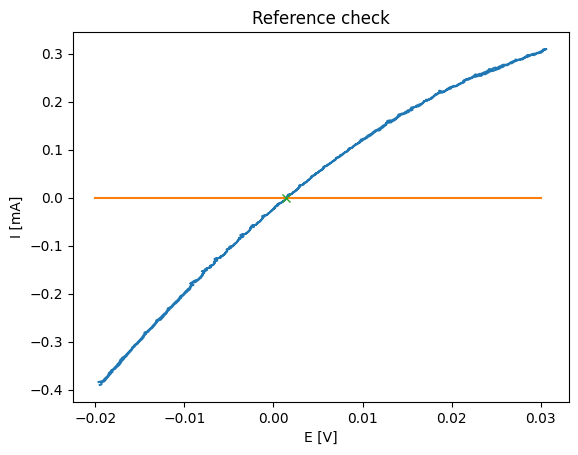

In [3]:
%autoreload
H2_file = filedialog.askopenfilename(title="Choose the file with CV under hydrogen.")
ref_V, ref_I = get_voltage_current(H2_file, index)
print("Chosen file:",H2_file)

x_lower_limit = -0.02
x_upper_limit = 0.03
reference = reference_check(ref_V, ref_I, x_lower_limit, x_upper_limit)

### 2. Choose which file(s) to analyze

#### 2A. Analysis of one file: Open the file with the interesting voltage and current data.

In [15]:
%autoreload
nbr_files = 1
file = filedialog.askopenfilename(title="Choose the file to be analyzed.")
V, I = get_voltage_current(file, index)
print(file)

L:/P15 SEM/Linnéa/2024_06_1112/Activity/ML00_M029_Cyc0001.txt


#### 2B. Analysis of several files: Open the files with the interestig voltage and current data.

In [4]:
%autoreload
nbr_files = 2 #not important, just not 1
files = filedialog.askopenfilenames(title="Choose the files to be analyzed.")
print(files)
data_matrix = []

for file in files: 
    V_i, I_i = get_voltage_current(file, index)
    data_matrix.append(V_i)
    data_matrix.append(I_i)

data_matrix = np.transpose(data_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_06_1112/Activity/ML00_M017_Cyc0015.txt', 'L:/P15 SEM/Linnéa/2024_06_1112/Activity/ML00_M018_Cyc0003.txt', 'L:/P15 SEM/Linnéa/2024_06_1112/Activity/ML00_M019_Cyc0003.txt', 'L:/P15 SEM/Linnéa/2024_06_1112/Activity/ML00_M020_Cyc0003.txt')


##### 2B.1 Optional: Rearrange the data so it's stored with the lowest rotation rate first.
###### Since the makrolist is ordered like 900, 1600, 2500, 400 rpm it is convenient to change places so that the 400 rpm voltage and current values are stored in the first columns of the data matrix. Otherwise you need to account for this in the plots so that the labels are correct.

In [5]:
V_400 = data_matrix[:,6]
I_400 = data_matrix[:,7]
data_matrix = np.insert(data_matrix, 0, V_400, axis=1)
data_matrix = np.insert(data_matrix, 1, I_400, axis=1)
data_matrix = np.delete(data_matrix, 8, axis=1)
data_matrix = np.delete(data_matrix, 8, axis=1)

### 3. Introduce background: choose the corresponding file(s)

In [6]:
%autoreload
if nbr_files == 1:
    background_file = filedialog.askopenfilename(title="Choose the background file.")
    print(background_file)
    background_V, background_I = get_background(background_file, index)
else:
    background_files = filedialog.askopenfilenames(title="Choose the background files.")
    print(background_files)
    background_matrix = []
    for i, background_file in enumerate(background_files): 
        V_i, I_i = get_background(background_file, index)
        background_matrix.append(V_i)
        background_matrix.append(I_i)

    background_matrix = np.transpose(background_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_06_1112/Activity/ML00_M005_Cyc0003.txt',)


### 4. Corrections
The following corrections can be made:
* Adjusting voltage to RHE potential.
* Background adjustment of current.
* iR-drop correction

In [7]:
%autoreload
if nbr_files == 1:
    background_V_RHE = copy.deepcopy(background_V)
    background_I_RHE = copy.deepcopy(background_I)
    V_RHE = copy.deepcopy(V)
    I_corrected = copy.deepcopy(I)

    background_V_RHE = RHE_correction(background_V_RHE, reference)
    V_RHE = RHE_correction(V_RHE, reference)
    I_corrected = background_correction_current(I_corrected, background_I_RHE)   
else:
    background_RHE = copy.deepcopy(background_matrix)
    background_RHE = RHE_correction_background(background_RHE, reference)
    data_RHE = copy.deepcopy(data_matrix)
    corrected_data_RHE = copy.deepcopy(data_matrix)
    
    for i in range(len(data_matrix[0])):
        if i % 2 == 0:      #voltage are stored in even indexed columns
            data_RHE[:,i] = RHE_correction(data_RHE[:,i], reference)
            corrected_data_RHE[:,i] = RHE_correction(corrected_data_RHE[:,i], reference)
        else:               #current
            corrected_data_RHE[:,i] = background_correction_current(corrected_data_RHE[:,i], background_RHE[:,1])
            #last index need to be changed to i if you have one background file for each data file

### 5. Normalizing to geometric surface area and mass

In [8]:
%autoreload
if nbr_files == 1:
    mass_I = copy.deepcopy(I_corrected)
    surface_I = copy.deepcopy(I_corrected)

    mass_I, surface_I = normalizing(mass_I, loading, A_geo)
else:
    mass_matrix = copy.deepcopy(corrected_data_RHE)
    surface_matrix = copy.deepcopy(corrected_data_RHE) 

    for i in range(1, len(data_matrix[0]), 2):  #only looping the current columns
        mass_matrix[:,i], surface_matrix[:,i] = normalizing(mass_matrix[:,i], loading, A_geo)

### 6. Plotting
Plotting polarisation curves.

Text(0.5, 1.0, 'Background corrected current density')

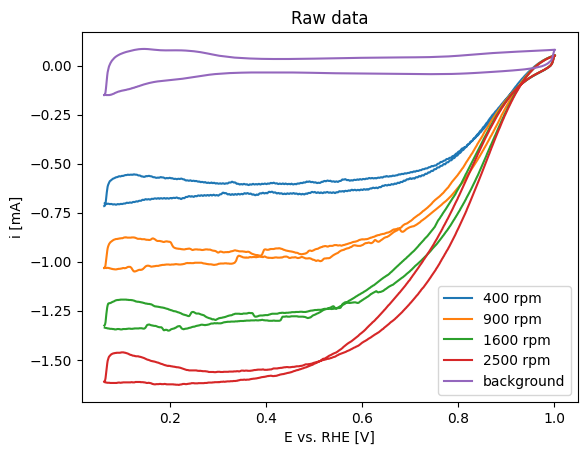

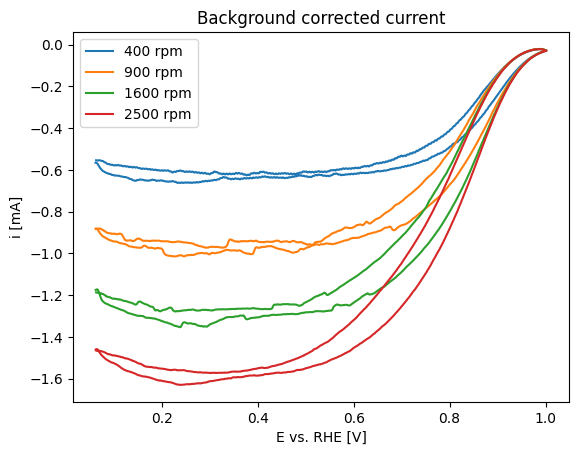

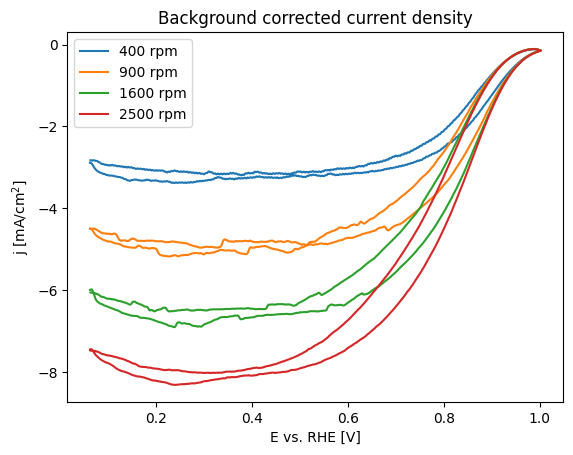

In [9]:
legend = ["400 rpm", "900 rpm", "1600 rpm", "2500 rpm", "background"]

fig1, ax1 = plt.subplots()
for i in range(0,len(data_RHE[0]),2):
    ax1.plot(data_RHE[:,i], data_RHE[:,i+1])
ax1.plot(background_RHE[:,0], background_RHE[:,1])
ax1.legend(legend, loc='lower right')  
ax1.set_xlabel('E vs. RHE [V]')
ax1.set_ylabel('i [mA]')
ax1.set_title('Raw data')

fig2, ax2 = plt.subplots()
for i in range(0,len(data_matrix[0]),2):
    ax2.plot(corrected_data_RHE[:,i],corrected_data_RHE[:,i+1])
ax2.legend(legend)
ax2.set_xlabel('E vs. RHE [V]')
ax2.set_ylabel('i [mA]')
ax2.set_title('Background corrected current')

fig3, ax3 = plt.subplots()
for i in range(0,len(data_matrix[0]),2):
    ax3.plot(surface_matrix[:,i],surface_matrix[:,i+1])
ax3.legend(legend)
ax3.set_xlabel('E vs. RHE [V]')
ax3.set_ylabel('j [mA/cm$^2$]')
ax3.set_title('Background corrected current density')

### 7. Analysis

#### 7.1 ECSA and activity calculation.
Look at the CO stripping file.

Specific ECSA CO str: 58.064183316367554 m2/g(Pt) 	ECSA CO str: 1.1380579930008041 cm2 
Specific ECSA HUPD:   55.07838208251557 m2/g(Pt) 	ECSA HUPD: 1.079536288817305 cm2
	-------------------------------------------------------------------


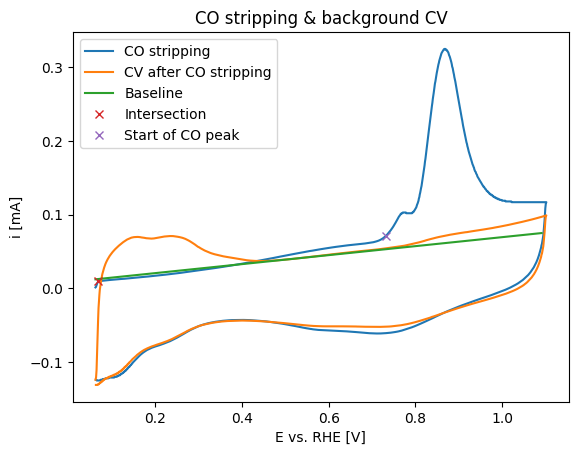

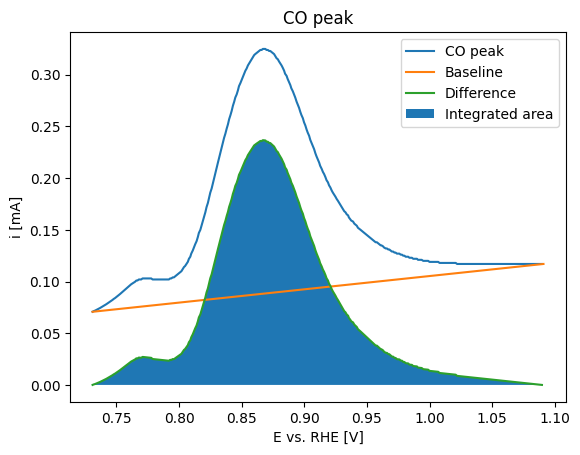

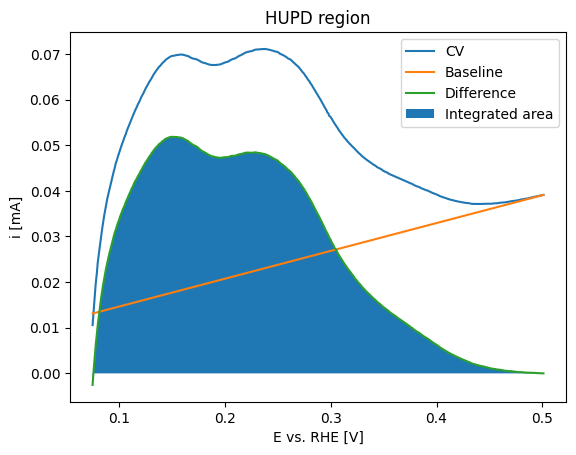

In [53]:
%autoreload
lower_voltage = 0.06   #from your macrolist
upper_voltage = 1.09
# The following values need to be tuned
DL_start = 0.50   #determines the starting point for your baseline
DL_end = 0.55     #determines the end point for your baseline
atol = 0.5        #determines the threshold where the CO peak deviates too much from baseline 

ecsa_calculation = ECSA_calculation(V_RHE, I, background_V_RHE, background_I)

specific_ECSAs, ECSAs = ecsa_calculation.calculating_ECSA(
    lower_voltage,
    upper_voltage,
    DL_start,
    DL_end,
    atol,
    scan_rate,
    charge_ecsa,
    Pt_mass,
)

ecsa_calculation.plotting()

##### Calculating specific and mass activities.
$SA = \frac{\frac{I*I_d}{I_d-I}}{ECSA} = \frac{I_k}{ECSA}$

$MA = \frac{I_k}{ECSA}$

In [54]:
%autoreload
diffusion_voltage = 0.40
kinetic_voltage = 0.90

I_d, I_k, SA_CO, SA_hupd, MA = obtain_activities(diffusion_voltage, kinetic_voltage, corrected_data_RHE, specific_ECSAs, Pt_mass)

Diffusion limiting current at 0.4 V and 1600 rpm V [mA]:
 1.30604971

Specific activity (CO) at 0.9 V and 1600 rpm [mA/cm2]:
 0.6575411350756616

Specific activity (HUPD) at 0.9 V and 1600 rpm [mA/cm2]:
 0.6931864655698663

 Mass activity at 0.9 V and 1600 rpm [mA/ug(Pt)]:
 0.3817958900508562


### 8. Export data to csv file.

In [14]:
# First argument determines the name of the file to be saved, 
# second is the data (numpy array) you want to save.
np.savetxt('exported_data_RHE', data_RHE, delimiter=",")

#### Bonus: Koutecký-Levich analysis

KL equation: $\frac{1}{i} = \frac{1}{i_k} + \frac{1}{i_m}$

$i$: measured current  
$i_k$: kinetic current, electron transfer limitations   
$i_m$: mass transfer limited current

$\frac{1}{i} = \frac{1}{nFC_Rk_f} + \frac{1}{0.62nFAC_RD^{2/3}\nu^{-1/6}} \cdot \frac{1}{\omega^{1/2}}$

In [ ]:
F = 96485
C = 1.2*pow(10,-6)
D23 = 7.12*pow(10,-4)
nu = 2.15443469

f = [400, 900, 1600, 2500]   #rpm
w = [2*np.pi*i/60 for i in f]   #to rad/s

diffusion_voltage = 0.40
kinetic_voltage = 0.90

diffusion_points = []
kinetic_points = []
for i in range(0,len(corrected_data_RHE[0]),2):  
    V_list = list(corrected_data_RHE[:,i])
    elm_i_diffusion = next(x for x in V_list if x >= diffusion_voltage)
    point_i_diffusion = corrected_data_RHE[V_list.index(elm_i_diffusion)][i+1]
    diffusion_points.append(point_i_diffusion)

    elm_i_kinetic = next(x for x in V_list if x >= kinetic_voltage)
    point_i_kinetic = corrected_data_RHE[V_list.index(elm_i_kinetic)][i+1]
    kinetic_points.append(point_i_kinetic)

x = [1/np.sqrt(i) for i in w]
y_diffusion = [1/(1000*i) for i in diffusion_points]
y_kinetic = [1/(1000*i) for i in kinetic_points]

# Linear regression
model1 = np.polyfit(x,y_diffusion,1)
print("Diffusion region: y=",round(model1[0],3),"* x +", round(model1[1],3))
predict1 = np.poly1d(model1)

model2 = np.polyfit(x,y_kinetic,1)
print("Kinetic region: y=",round(model2[0],3),"* x + ", round(model2[1],3))
predict2 = np.poly1d(model2)

#Model accuracy
from sklearn.metrics import r2_score
R2_diffusion = r2_score(y_diffusion, predict1(x))
R2_kinetic = r2_score(y_kinetic, predict2(x))
print('\nR-value diffusion model: ',R2_diffusion,'\nR-value kinetic model: ',R2_kinetic)

#Plotting
x_lin_reg = np.linspace(np.min(x), np.max(x))
plt.scatter(x, y_diffusion, c="black")
y_reg_diffusion = predict1(x_lin_reg)
plt.plot(x_lin_reg, y_reg_diffusion, label = "diffusion limit")

plt.scatter(x, y_kinetic, c="black")
y_reg_kinetic = predict2(x_lin_reg)
plt.plot(x_lin_reg, y_reg_kinetic, label = "kinetic region")

plt.xlabel("$\\omega^{-1/2}$")
plt.ylabel("1/i [mA$^{-1}$]")
plt.xlim([0, 0.18])   #this might need to be adjusted
plt.grid()
plt.legend()